# **<center> SPATIOTEMPORAL SEGMENTATION OF SATELLITE IMAGE TIME SERIES USING SELF-ORGANIZING MAP**


**<center> Abstract**. This Jupyter Notebook describes how to work with sits R package. It shows how to perform satellite time series classification using machine learning algorithms. It starts by accessing time series in a local data cube. After the local cube is created. Time series are extracted from the data cube using a predefined sample set. Next, a machine learning model is trained on the time series. This demonstrates the generation of a thematic map from the trained model. Finally, post-processing and evaluation of the results of the generated thematic maps are applied 


Sentinel-2 tratament                       

![](https://drive.google.com/uc?export=view&id=1KGJ4sMydcHXSg1R8zWcT2np18gzjeaYo)


## **Download required libraries**

In [1]:
!pip install rasterio==1.2.10
!pip install xpysom==1.0.7
!pip install geopandas==0.10.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 236 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for xpysom: filename=XPySom-1.0.7-py3-none-any.whl size=28912 sha256=16a94b700f22a874508e9939d78d4ac8bb2d3dd0c6c466f365c3234aeecbd245
  Stored in directory: /root/.cache/pip/wheels/eb/9a/5a/c3c301e18cdcbecb463b4fd08f4381dddb43a84e5f06bd45ef
Successfully built xpysom
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.0 MB/s 
     |████████████████████████████████| 16.7 MB 307 kB/s 
     |████████████████████████████████| 6.3 MB 52.5 MB/s 


## **Downloading and unzipping the images**

In [2]:
!gdown --id 1DG9nW8tM-uKV8pthre36nxdqBWRE0_MV

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1DG9nW8tM-uKV8pthre36nxdqBWRE0_MV
To: /content/st_segmentation.zip
100% 275M/275M [00:02<00:00, 97.3MB/s]


In [3]:
!unzip "/content/st_segmentation.zip" 

Archive:  /content/st_segmentation.zip
   creating: bundle/
   creating: bundle/Rcpp/
  inflating: bundle/Rcpp/CITATION    
  inflating: bundle/Rcpp/DESCRIPTION  
  inflating: bundle/Rcpp/INDEX       
   creating: bundle/Rcpp/Meta/
  inflating: bundle/Rcpp/Meta/Rd.rds  
  inflating: bundle/Rcpp/Meta/features.rds  
  inflating: bundle/Rcpp/Meta/hsearch.rds  
  inflating: bundle/Rcpp/Meta/links.rds  
  inflating: bundle/Rcpp/Meta/nsInfo.rds  
  inflating: bundle/Rcpp/Meta/package.rds  
  inflating: bundle/Rcpp/Meta/vignette.rds  
  inflating: bundle/Rcpp/NAMESPACE   
  inflating: bundle/Rcpp/NEWS.Rd     
   creating: bundle/Rcpp/R/
  inflating: bundle/Rcpp/R/Rcpp      
  inflating: bundle/Rcpp/R/Rcpp.rdb  
  inflating: bundle/Rcpp/R/Rcpp.rdx  
   creating: bundle/Rcpp/announce/
  inflating: bundle/Rcpp/announce/ANNOUNCE-0.10.0.txt  
  inflating: bundle/Rcpp/announce/ANNOUNCE-0.11.0.txt  
  inflating: bundle/Rcpp/announce/ANNOUNCE-0.6.0.txt  
  inflating: bundle/Rcpp/announce/ANNOUNCE-0.7

In [4]:
#loading libraries
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from datetime import date, datetime
import os
from osgeo import ogr
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import time
import glob
import math
from xpysom import XPySom  

## Loading the images and placing the array in the correct way.

In [5]:
%%time
path = "/content/s2//*.tif"
image_names = glob.glob(path)
image_names.sort()
data = []
for name in image_names:
      with rio.open(name) as dataset:
          asset = dataset.read(1).flatten()
          data.append(asset)
row = dataset.width
col = dataset.height
data = np.array(data).T

CPU times: user 2.74 s, sys: 220 ms, total: 2.96 s
Wall time: 4.12 s


In [6]:
data.shape

(4275352, 23)

# **Model training phase**

In [7]:
%%time
n=12
som = XPySom(n,n, len(data[0]),
            random_seed=123, n_parallel=10000)
som.train(data, 20)

CPU times: user 14.9 s, sys: 1.66 s, total: 16.6 s
Wall time: 21.2 s


## **Model predition phase**

In [8]:
%%time
predictions = som.winner(data)

CPU times: user 4.45 s, sys: 413 ms, total: 4.86 s
Wall time: 4.84 s


## **Transforming to integer for ploting**

In [9]:
%%time
position=[str((i,j)) for i in range(n) for j in range(n)]
position = {pos:position.index(pos) for pos in position}
for i in range(len(predictions)):
    predictions[i] = position[f'{predictions[i]}']
predictions = np.array(predictions).astype("int")

CPU times: user 5.2 s, sys: 39.5 ms, total: 5.24 s
Wall time: 5.24 s


## **Unsupervised classification map with 144 patterns corresponding to the size of the SOM grid**

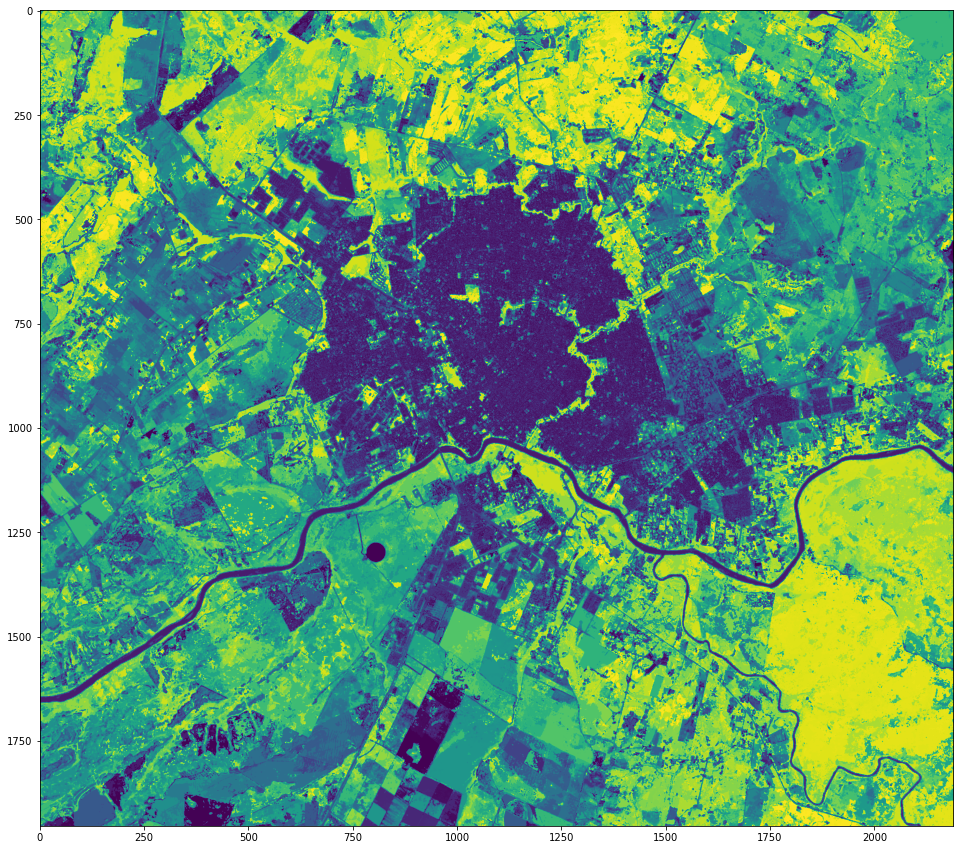

In [10]:
image =predictions.reshape(col,row)
plt.figure(figsize=(40,15))
plt.imshow(image)

## **At this stage, hierarchical clustering is applied for dimensionality reduction, where 144 patterns will be summarized into 4**

In [11]:
neuron_weights = [som.get_weights()[i][j] for i in range(n) for j in range(n)]

In [12]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#ffa200','#006305','#ffff00','#004ab3'])

CPU times: user 196 ms, sys: 6.62 ms, total: 203 ms
Wall time: 211 ms


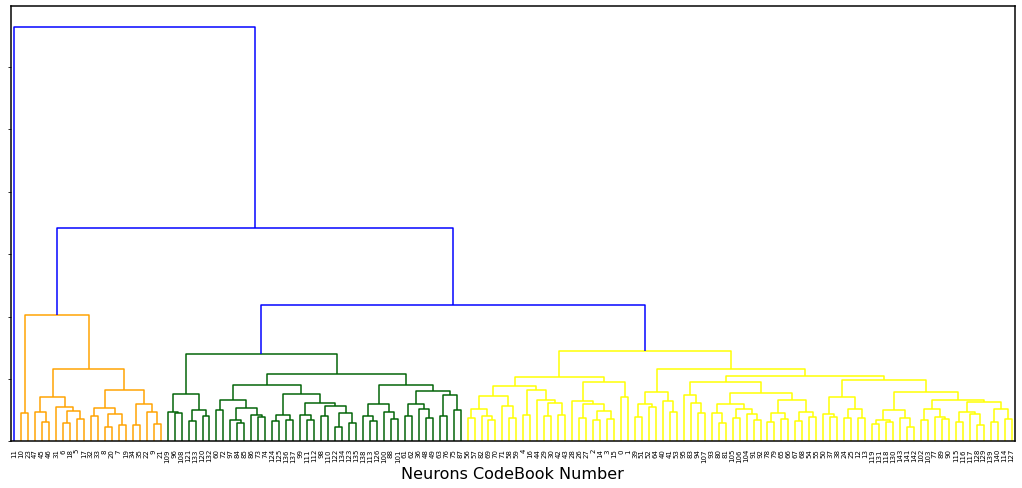

In [13]:
%%time
colors = ['#ffa200','#006305' ,'#ffff00']
(fig, ax) = plt.subplots(figsize=(18, 8), sharey=True)
X = np.array(neuron_weights)
sch.set_link_color_palette(colors)
dendrogram = sch.dendrogram(sch.linkage(X, method='average'),color_threshold=10500,leaf_font_size=7)
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')#,distance_threshold=10000)
model.fit(X)
labels = model.labels_

plt.xlabel('Neurons CodeBook Number', fontsize=16)
ax.spines['left'].set_lw(1.5)
ax.spines['bottom'].set_lw(1.5)
ax.spines['right'].set_lw(1.5)
ax.spines['top'].set_lw(1.5)
ax.set_yticklabels([])

## **Map showing the SOM grid in 4 clusters represented by the colors and the cluster number**

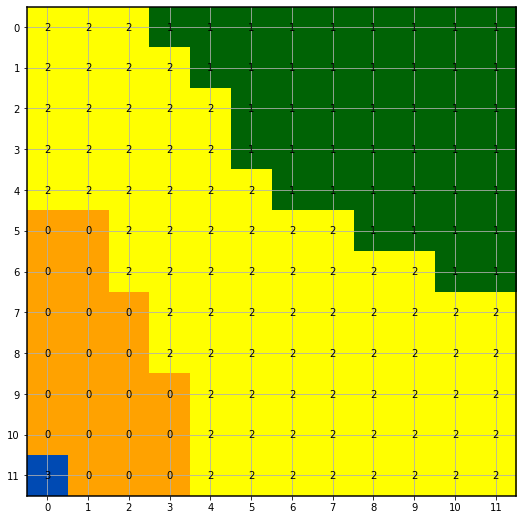

In [14]:
mlabels = labels.reshape(n,n)
(fig, ax) = plt.subplots(figsize=(9, 9), sharey=True)
for i in range(n):
    for j in range(n):
        neuron_index = i * n + j
        ax.text(i, j, str(mlabels[i][j]), va='center', ha='center')
ax.imshow(np.array(mlabels).T, cmap=cmap, interpolation='none')
ax.grid(True)
plt.xticks(range(n))
plt.yticks(range(n))
ax.spines['left'].set_lw(1.5)
ax.spines['bottom'].set_lw(1.5)
ax.spines['right'].set_lw(1.5)
ax.spines['top'].set_lw(1.5)
plt.savefig("matrixdend.png",bbox_inches='tight')


In [15]:
dendrogram = predictions.copy()
for i in range(len(labels)):
        dendrogram = np.where(predictions == i, labels[i], dendrogram )
image1 = dendrogram.reshape(col,row)

## **Unsupervised classification map with 4 clusters corresponding with the output of the hierarchical clustering** 

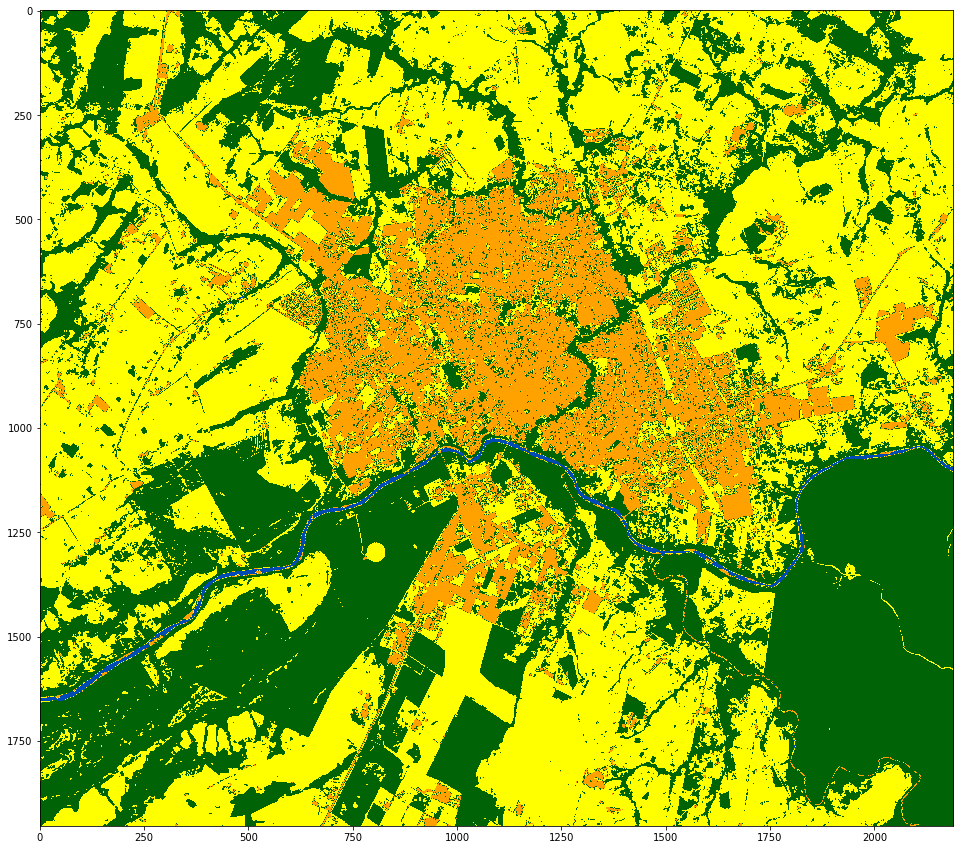

In [16]:

plt.figure(figsize=(40,15))
plt.imshow(image1,cmap=cmap)

## **Map with the patterns of each SOM neuron and its respective color for the final cluster**

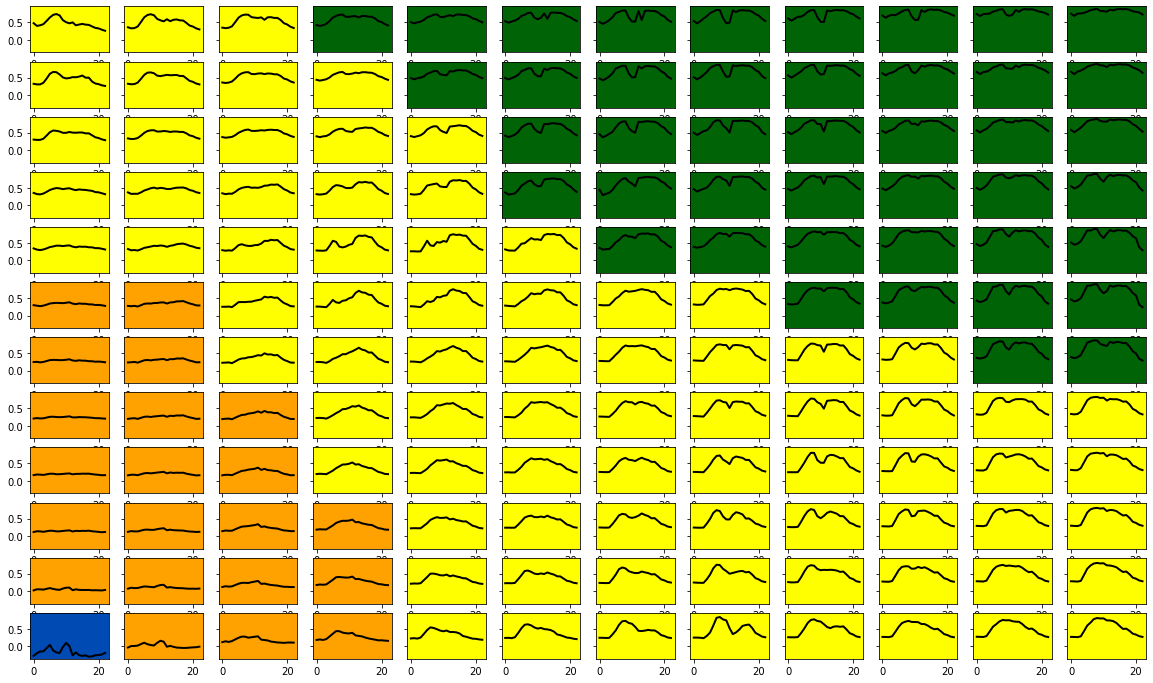

In [17]:
fig, axs = plt.subplots(n,n,figsize=(20,12) ,sharey=True)#,constrained_layout=True)
for neuron_index,neuron in enumerate(neuron_weights):
    col1 = math.floor(neuron_index/n)
    row1 = neuron_index % n
    axs[row1, col1].plot(neuron/10000,linewidth=2,color='black')

    # axs[row1, col1].set_ylabel('NDVI')
    # axs[row1, col1].set_xlabel('TIME')
    # #axs[row1, col1].yaxis.label.set_color('red')
    # #plt.yticks([-1,0,1])
    # axs[row1, col1].spines['left'].set_lw(1.5)
    # axs[row1, col1].spines['bottom'].set_lw(1.5)
    # axs[row1, col1].spines['right'].set_lw(1.5)
    # axs[row1, col1].spines['top'].set_lw(1.5)
    # axs[row1, col1].set_title('neuron '+str(neuron_index),fontsize=22)

    if neuron_index in np.unique(predictions[np.where(dendrogram==0)]):
        axs[row1, col1].set_facecolor('#ffa200')
    elif neuron_index in np.unique(predictions[np.where(dendrogram==1)]):
        axs[row1, col1].set_facecolor('#006305')
    elif neuron_index in np.unique(predictions[np.where(dendrogram==2)]):
        axs[row1, col1].set_facecolor('#ffff00')
    else:
        axs[row1, col1].set_facecolor('#004ab3')
    # # y_ticks = np.arange(-0.5, 1, 0.3)
    # # plt.yticks(y_ticks)


plt.show()
    


## Calling R notebook

In [18]:
arv = 's2_12x12_20_4clust_NDVI'
image1 = np.array(image1)

xmin,ymin,xmax,ymax= [-54.7418,-16.5599,-54.5348,-16.3860]

nrows,ncols =col,row
xres = (xmax-xmin)/float(ncols)
yres = (ymax-ymin)/float(nrows)
geotransform=(xmin,xres,0,ymax,0, -yres)

output_raster = gdal.GetDriverByName('GTiff').Create(arv+".tif",ncols, nrows, 1 ,gdal.GDT_Float32) 
output_raster.GetRasterBand(1).WriteArray(image1)
output_raster.SetGeoTransform(geotransform)  
srs = osr.SpatialReference()                 
srs.ImportFromEPSG(4326)                     
                                                                                        
output_raster.SetProjection( srs.ExportToWkt() )                                                  
output_raster.FlushCache()
output_raster = None

In [19]:
!python3 -m pip install papermill==2.3.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 8.2 MB/s 
     |████████████████████████████████| 130 kB 32.5 MB/s 
     |████████████████████████████████| 428 kB 63.6 MB/s 
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.1.1
    Uninstalling traitlets-5.1.1:
      Successfully uninstalled traitlets-5.1.1
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=5.1.0; pytho

In [20]:
!papermill /content/post_processing_smoothed.ipynb /content/results.ipynb

Input Notebook:  /content/post_processing_smoothed.ipynb
Output Notebook: /content/results.ipynb
Executing:   0% 0/4 [00:00<?, ?cell/s]Executing notebook with kernel: ir
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libudunits2-0 libudunits2-data
The following NEW packages will be installed:
  libudunits2-0 libudunits2-data libudunits2-dev
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 435 kB of archives.
After this operation, 1,034 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libudunits2-data all 2.2.26-1 [18.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libudunits2-0 amd64 2.2.26-1 [54.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/unive

## **Vectorizing the Map and creating the final segments**

In [21]:
smoothed_tif = '/content/s2_12x12_20_4clust_NDVI_smoothed'
open_image = gdal.Open( smoothed_tif+".tif")
input_band = open_image.GetRasterBand(1)
output_shp = smoothed_tif+"vec"
shp_driver = ogr.GetDriverByName("ESRI Shapefile")
# create output file name
output_shapefile = shp_driver.CreateDataSource( output_shp
+ ".shp" )
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)
new_shapefile = output_shapefile.CreateLayer(output_shp,srs )
gdal.Polygonize(input_band, None, new_shapefile, -1, [],callback=None)
new_shapefile.SyncToDisk()

0

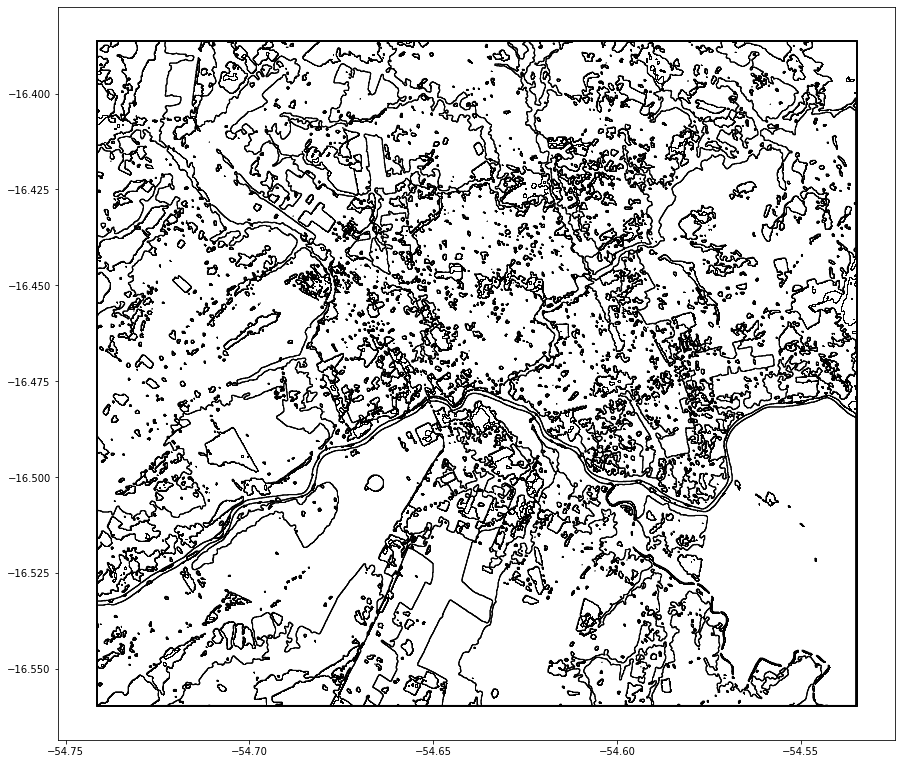

In [22]:
import geopandas as gpd
shapefile = gpd.read_file(smoothed_tif+"vec.shp")
shapefile.plot(figsize=(15,15), edgecolor="black", facecolor="none")

## Calling R notebook

In [23]:
!papermill /content/post_processing_segmetric.ipynb  /content/results_segmetric.ipynb

Input Notebook:  /content/post_processing_segmetric.ipynb
Output Notebook: /content/results_segmetric.ipynb
Executing:   0% 0/4 [00:00<?, ?cell/s]Executing notebook with kernel: ir
Executing: 100% 4/4 [00:06<00:00,  1.53s/cell]
Execution halted
Executing: 100% 4/4 [00:06<00:00,  1.54s/cell]


In [24]:
import pandas

In [25]:
result = pandas.read_csv('/content/results_validation.csv')

In [26]:
result = result['x'].str.split(' ', expand=True)
result.columns= ['Metric','Value']
result

,Metric,Value
0,F_measure,0.853376282605077
1,recall,0.877609938492276
2,precision,0.830445003496556
3,M,0.645750864425084
